In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from method import IV
from simulator import Simulator
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_plot import savefig, fix_figure, despine, set_style, add_caption
import copy
from IPython.display import display
import statsmodels.api as sm
import matplotlib.lines as mlines
from matplotlib.ticker import ScalarFormatter

In [2]:
def mean_square_error(x1, x2):
    return np.sum((x2 - x1)**2) / len(x1.dropna())

def normalize(x, y):
    a = x - x.min()
    return a / a.max() * y.max()

In [3]:
trials = [5000, 10000, 15000, 20000, 25000, 30000]
sim_id = [1, 2, 3]
# path = 'results/orig_analysis/'
path = 'results/'

iv_name = 'iv_wald'
varis = [iv_name, 'cch']
proxies = ['IV', 'CCH']

In [4]:
mse_trials = {var: {sid: list() for sid in sim_id} for var in varis}

for sid in sim_id:
    for N_trials in trials:
        analys = pd.read_csv(path + 'params_{}_analyse_{}.csv'.format(sid, N_trials))
        analys = analys.loc[(analys.pfast < 0.01) & (analys.ppeak < 0.01),:]
#         analys = analys.loc[(analys.pfast < 0.01),:]
        for var in varis:
            estimate, true = analys[var], analys['weight']
            true = normalize(true, estimate)
            mse_trials[var][sid].append(mean_square_error(estimate, true))

In [5]:
binsize = .1
hit_rate = {var: {sid: {'vals': list(), 'bins': None} for sid in sim_id} for var in varis}
N_trials = 30000
for sid in sim_id:
    analys = pd.read_csv(path + 'params_{}_analyse_{}.csv'.format(sid, N_trials))
    analys = analys.loc[(analys.pfast < 0.01) & (analys.ppeak < 0.01),:]
    mi, ma = analys.hit_rate.min().round(1), analys.hit_rate.max().round(1)
    bins = np.arange(mi, ma + binsize, binsize).round(2)[:-1]
    for var in varis:
        estimate, true = analys[var], analys['weight']
        true = normalize(true, estimate)
        hit_rate[var][sid]['bins'] = bins
        for b1, b2 in zip(bins, bins[1:]):
            mask = (analys.hit_rate >= b1) & (analys.hit_rate < b2)
            hit_rate[var][sid]['vals'].append(mean_square_error(true[mask], estimate[mask]))

$g$ = 9.9 = -0.42
$g$ = 4.4 = -0.54
$g$ = 3.0 = -0.31


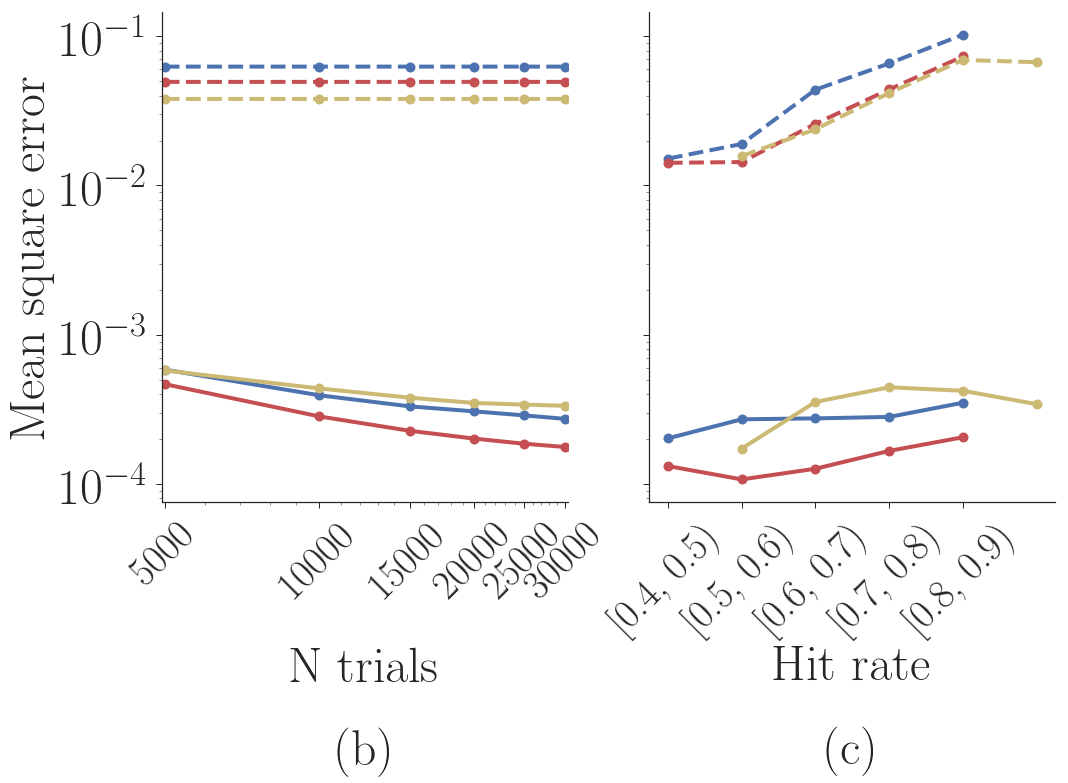

In [6]:
save = False
if save: set_style('article', sns_style='ticks')
if not save: set_style('notebook', sns_style='ticks')

fig, (ax_t, ax_h) = plt.subplots(1, 2, sharey=True)
legend = {
    1: '$g$ = 9.9',
    2: '$g$ = 4.4',
    3: '$g$ = 3.0'
}
color = {
    1: 'b',
    2: 'r',
    3: 'y'
}
h = []

for sid in sim_id:
    slope, intercept = np.polyfit(np.log(trials), np.log(mse_trials[iv_name][sid]), 1)
    print('{} = {:.2f}'.format(legend[sid], slope))
    for var, name, ls in zip([iv_name, 'cch'], ['IV, ', 'CCH, '], ['-', '--']):
        # mse trials
        a, = ax_t.loglog(
            trials, mse_trials[var][sid], ls=ls, 
            label=name + legend[sid], color=color[sid], marker='.')
        # mse hit rate
        ax_h.semilogy(
            hit_rate[var][sid]['bins'][:-1], hit_rate[var][sid]['vals'], ls=ls, 
            label=name + legend[sid], color=color[sid], marker='.')
        h.append(a)
    
despine(xticks=True, yticks=True, ax=ax_t)
despine(xticks=True, yticks=False, ax=ax_h)

# iv = mlines.Line2D([], [], color='k', ls='-', label='IV')
# cch = mlines.Line2D([], [], color='k', ls='--', label='CCH')
# h.extend([iv,cch])
# plt.legend(handles=h, bbox_to_anchor=(-1.25, 1.02, 2.2, .102), loc=3,
#            ncol=4, mode="expand", borderaxespad=0.)
ax_t.set_ylabel('Mean square error')



# mins = sorted([np.min(mse_trials[v][sid]).round(5) for sid in sim_id for v in varis])
# mins = [min(mins), max(mins)]
mins = [1e-1, 1e-2, 1e-3, 1e-4]
ax_t.set_yticks(mins, minor=False)


ax_t.xaxis.set_major_formatter(ScalarFormatter())
ax_t.set_xticks(np.arange(5000, 30000, 1000), minor=True)
ax_t.set_xticklabels([], minor=True)
ax_t.set_xticks(trials, minor=False)
ax_t.set_xticklabels(trials, minor=False, rotation=45)
ax_t.set_xlim([4950, 30500])
ax_t.set_xlabel('N trials')

bins = hit_rate['cch'][1]['bins']
xticks = ['[{}, {}{}'.format(b1, b2, ')' if b2 < 1.0 else ']') for b1, b2 in zip(bins, bins[1:])]
ax_h.set_xticks(bins[:-1])
ax_h.set_xticklabels(xticks, rotation=45)
ax_h.set_xlabel('Hit rate')
add_caption([ax_t, ax_h], start='b')
fig.align_labels()
# if save: savefig(fig, 'mse', bbox_inches='tight')